In [1]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import nibabel as nib
from tqdm import tqdm
import math
import csv
import time 

import torchvision.transforms as transforms
import torch
import torch.nn as nn
from torch.nn.functional import relu
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from skimage.transform import resize

#import geoopt
import cv2

In [2]:
# !mkdir -p ~/.kaggle
# !cp /kaggle/input/kaggle-json/kaggle.json ~/.kaggle/
# !chmod 600 ~/.kaggle/kaggle.json

# !kaggle kernels output manideepikas/unet-liver-256 -p /kaggle/working/unet-liver-output

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
class Config:

    train_dir = '/kaggle/input/3d-liver-segmentation/Task03_Liver_rs/imagesTr'
    labels_dir = '/kaggle/input/3d-liver-segmentation/Task03_Liver_rs/labelsTr'


    vol_paths = list()
    seg_paths = list()

    n_classes = 1
    vols_count = None
    segs_count = None

    window = (-30,140)
    batch_size = 16
    learning_rate = 1e-3

In [5]:
for file in os.listdir(Config.train_dir):
    if file.endswith('.nii'):

        Config.vol_paths.append(os.path.join(Config.train_dir,file))
        Config.seg_paths.append(os.path.join(Config.labels_dir,file))

Config.vols_count = len(Config.vol_paths)
Config.segs_count = len(Config.seg_paths)

print('Total CT Scan Volumes for Train:', Config.vols_count)
print('Total Segmentation masks:', Config.segs_count)

Total CT Scan Volumes for Train: 123
Total Segmentation masks: 123


In [6]:
path = Config.vol_paths[1]
data = nib.load(path).get_fdata().transpose(2,1,0)
seg = nib.load(Config.seg_paths[1]).get_fdata().transpose(2,1,0)

In [7]:
seg.shape

(183, 210, 210)

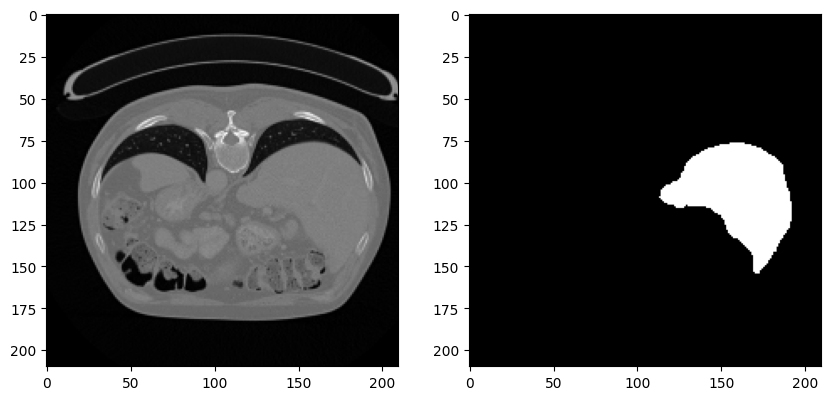

In [8]:
_, axes = plt.subplots(1,2, figsize = (10,5))
axes[0].imshow(data[150], cmap = 'gray')
axes[1].imshow(seg[150], cmap = 'gray')
plt.show()

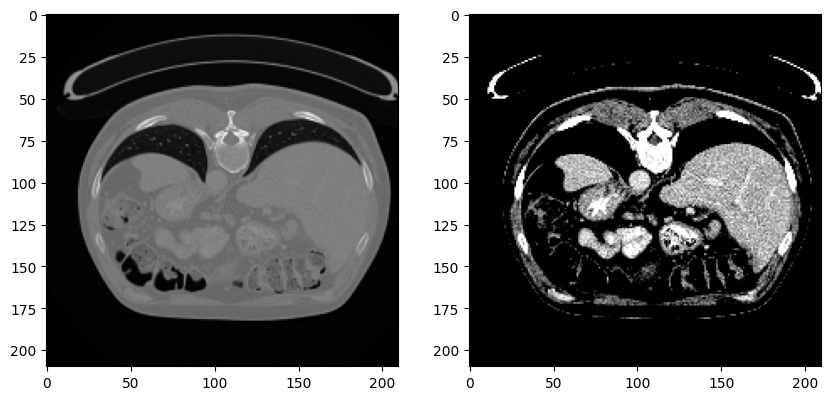

In [9]:
win_img = np.clip(data[150], -30,140)
_, axes = plt.subplots(1,2, figsize = (10,5))
axes[0].imshow(data[150], cmap = 'gray')
axes[1].imshow(win_img, cmap = 'gray')
plt.show()

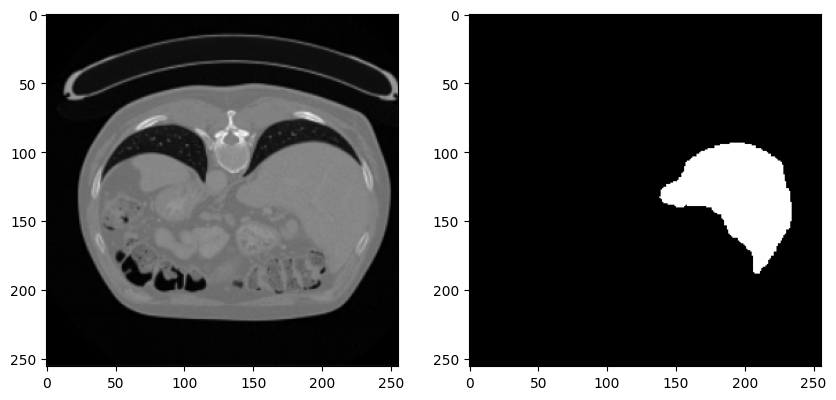

In [10]:
resized_X = resize(data[150], (256, 256), mode='constant', preserve_range=True, anti_aliasing=True)
resized_Y = resize(seg[150], (256, 256), mode='constant', preserve_range=True, order=0)

_, axes = plt.subplots(1,2, figsize = (10,5))
axes[0].imshow(resized_X, cmap = 'gray')
axes[1].imshow(resized_Y, cmap = 'gray')
plt.show()

In [11]:
def preprocess(ct_scan: np.ndarray, window: tuple = Config.window) -> np.ndarray:
    """Applying windowing for given Data and Normalizing"""
    min_value, max_value = window

    # Apply windowing
    windowed_ct = np.clip(ct_scan, min_value, max_value)

    # Normalize to 0-1
    windowed_ct = ((windowed_ct - min_value) / (max_value - min_value))

    return windowed_ct

In [12]:
# dataset = []

# for idx,seg_path in tqdm(enumerate(Config.seg_paths)):
#     seg = nib.load(seg_path).get_fdata().transpose(2, 1, 0)
    
#     for slice_idx, mask in enumerate(seg):
#         liver_mask = mask.sum() > 0 
#         dataset.append((slice_idx, liver_mask, Config.vol_paths[idx], Config.seg_paths[idx]))

In [13]:
dataset = None

if dataset is not None:
    dataset = pd.DataFrame(dataset, columns = ['slice_idx', 'liver_mask_exists', 'vol_path', 'seg_path'])
    dataset.to_csv('liver-path-data.csv', index= False)
else:
    dataset = pd.read_csv('/kaggle/input/liver-path-data/liver-path-data.csv')

dataset.head()

,slice_idx,liver_mask_exists,vol_path,seg_path
0,0,False,/kaggle/input/3d-liver-segmentation/Task03_Liv...,/kaggle/input/3d-liver-segmentation/Task03_Liv...
1,1,False,/kaggle/input/3d-liver-segmentation/Task03_Liv...,/kaggle/input/3d-liver-segmentation/Task03_Liv...
2,2,False,/kaggle/input/3d-liver-segmentation/Task03_Liv...,/kaggle/input/3d-liver-segmentation/Task03_Liv...
3,3,False,/kaggle/input/3d-liver-segmentation/Task03_Liv...,/kaggle/input/3d-liver-segmentation/Task03_Liv...
4,4,False,/kaggle/input/3d-liver-segmentation/Task03_Liv...,/kaggle/input/3d-liver-segmentation/Task03_Liv...


In [14]:
print("Total CT slices: ", len(dataset))
print("Slices with Liver: ", sum(dataset.liver_mask_exists))

Total CT slices:  19604
Slices with Liver:  6413


In [15]:
# # OverSampling Liver mask slices
# liver_mask_slices = dataset[dataset.liver_mask_exists]

# dataset = pd.concat([dataset, liver_mask_slices], ignore_index=True)

# dataset = dataset.sample(frac=1, random_state=42).reset_index(drop=True)

# print("Total CT slices: ", len(dataset))
# print("Slices with Liver: ", sum(dataset.liver_mask_exists))
# print("Slices without Liver: ",len(dataset) - sum(dataset.liver_mask_exists))

In [16]:
class LiverDataset(Dataset):
    def __init__(self, data: list, transform=None):
        self.slice_data = data
        self.transform = transform

    def __len__(self):
        return len(self.slice_data)

    def __getitem__(self, idx):
        slice_idx, _, vol_path, seg_path = self.slice_data.iloc[idx]

        # Load volume and segmentation mask
        vol = nib.load(vol_path).get_fdata()
        seg = nib.load(seg_path).get_fdata()

        # Extract the corresponding slice
        X = vol[:, :, slice_idx].transpose(1,0)
        Y = seg[:, :, slice_idx].transpose(1,0) > 0

        # Resize images and masks
        X = resize(X, (256, 256), mode='constant', preserve_range=True, anti_aliasing=True)
        Y = resize(Y, (256, 256), mode='constant', preserve_range=True, order=0)  # Nearest-neighbor

        # Apply preprocessing 
        if self.transform:
            X = self.transform(X)

        # Add channel dimension
        X = np.expand_dims(X, axis=0)
        Y = np.expand_dims(Y, axis=0)

        # Convert to torch tensors
        X = torch.from_numpy(X).float()
        Y = torch.from_numpy(Y).float()

        return X, Y

In [17]:
train, test = train_test_split(dataset, test_size = 0.2, random_state = 42, stratify = dataset.liver_mask_exists)

In [18]:
train_dataset = LiverDataset(train, transform = preprocess)
train_dataloader = DataLoader(train_dataset, batch_size = Config.batch_size, shuffle = True)

val_dataset = LiverDataset(test, transform = preprocess)
val_dataloader = DataLoader(val_dataset, batch_size = Config.batch_size, shuffle = False)

In [19]:
class UNet(nn.Module):
    def __init__(self, n_classes):
        super().__init__()

        self.e11 = nn.Conv2d(1, 64, kernel_size=3, padding=1)
        self.e12 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.e21 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.e22 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.e31 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.e32 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.e41 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.e42 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.e51 = nn.Conv2d(512, 1024, kernel_size=3, padding=1)
        self.e52 = nn.Conv2d(1024, 1024, kernel_size=3, padding=1)


        self.upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.d11 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
        self.d12 = nn.Conv2d(512, 512, kernel_size=3, padding=1)

        self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.d21 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.d22 = nn.Conv2d(256, 256, kernel_size=3, padding=1) 

        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.d31 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.d32 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        self.upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.d41 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.d42 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

        self.outconv = nn.Conv2d(64, n_classes, kernel_size=1)
        self.activation = nn.Sigmoid()

    def init_weights(self, m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
            nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)


    def forward(self, x):
        # Encoder
        x = F.relu(self.e11(x))
        x1 = F.relu(self.e12(x))
        x = self.pool1(x1)

        x = F.relu(self.e21(x))
        x2 = F.relu(self.e22(x))
        x = self.pool2(x2)

        x = F.relu(self.e31(x))
        x3 = F.relu(self.e32(x))
        x = self.pool3(x3)

        x = F.relu(self.e41(x))
        x4 = F.relu(self.e42(x))
        x = self.pool4(x4)

        x = F.relu(self.e51(x))
        x = F.relu(self.e52(x))

        # Decoder
        x = self.upconv1(x)
        x = torch.cat([x,x4],dim=1)
        x = F.relu(self.d11(x))
        x = F.relu(self.d12(x))

        x = self.upconv2(x)
        x = torch.cat([x,x3],dim=1)
        x = F.relu(self.d21(x))
        x = F.relu(self.d22(x))

        x = self.upconv3(x)
        x = torch.cat([x,x2],dim=1)
        x = F.relu(self.d31(x))
        x = F.relu(self.d32(x))

        x = self.upconv4(x)
        x = torch.cat([x,x1],dim=1)
        x = F.relu(self.d41(x))
        x = F.relu(self.d42(x))

        out = self.outconv(x)

        return  self.activation(out)

In [20]:
def dice_score(pred, target, smooth=1e-6):
    intersection = torch.sum(pred * target, dim=(1,2,3))
    union = torch.sum(pred, dim=(1,2,3)) + torch.sum(target, dim=(1,2,3))

    dice_score = (2. * intersection + smooth) / (union + smooth)
    
    return dice_score.mean()

def dice_coefficient(preds, masks, smooth=1e-6):
    intersection = torch.sum(preds * masks, dim=(1,2,3))
    union = torch.sum(preds, dim=(1,2,3)) + torch.sum(masks, dim=(1,2,3))

    dice_score = (2. * intersection) / (union + smooth)

    valid_masks = union > 0
    if valid_masks.sum() == 0:  
        return torch.tensor(0, device = preds.device)

    return dice_score[valid_masks].mean() 

def dice_loss(preds, masks):
    return 1 - dice_coefficient(preds, masks)

def precision(preds, targets):

    targets = targets.float()

    tp = (preds * targets).sum()
    fp = (preds * (1 - targets)).sum()

    precision = tp / (tp + fp + 1e-8)
    return precision.item()

def recall(preds, targets):

    targets = targets.float()

    tp = (preds * targets).sum()
    fn = ((1 - preds) * targets).sum()

    recall = tp/ (tp + fn + 1e-8)
    return recall.item()

def mIou(pred, target):
    
    target = target.float()

    intersection = (pred * target).sum(dim=(1,2,3))
    union = (pred + target).sum(dim=(1,2,3)) - intersection 

    iou = (intersection) / (union + 1e-8)
    valid_masks = union > 0
    if valid_masks.sum() == 0:  
        return 0

    return iou[valid_masks].mean().item()

In [21]:
from torchsummary import summary

model = UNet(n_classes = Config.n_classes).to(device)

summary(model, (1,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 256, 256]             640
            Conv2d-2         [-1, 64, 256, 256]          36,928
         MaxPool2d-3         [-1, 64, 128, 128]               0
            Conv2d-4        [-1, 128, 128, 128]          73,856
            Conv2d-5        [-1, 128, 128, 128]         147,584
         MaxPool2d-6          [-1, 128, 64, 64]               0
            Conv2d-7          [-1, 256, 64, 64]         295,168
            Conv2d-8          [-1, 256, 64, 64]         590,080
         MaxPool2d-9          [-1, 256, 32, 32]               0
           Conv2d-10          [-1, 512, 32, 32]       1,180,160
           Conv2d-11          [-1, 512, 32, 32]       2,359,808
        MaxPool2d-12          [-1, 512, 16, 16]               0
           Conv2d-13         [-1, 1024, 16, 16]       4,719,616
           Conv2d-14         [-1, 1024,

## Inference

In [22]:
name = 'unet-bce'

In [23]:
model.load_state_dict(torch.load(f'/kaggle/input/{name}/Unet_dice_256_2.pth', weights_only=True))
model.eval()

UNet(
  (e11): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e12): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e21): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e22): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e31): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e32): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e41): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (e42): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (e51): Conv2d(512, 1024, kernel_size=(

In [24]:
dice_tm = []
dice = []
miou = []
for imgs, masks in tqdm(val_dataloader):
    imgs = imgs.to(device)
    masks = masks.to(device)

    preds = (model(imgs) > .5).float()
    
    dice_tm.append(dice_coefficient(preds, masks).item())
    dice.append(dice_score(preds, masks).item())
    miou.append(mIou(preds, masks))

100%|██████████| 246/246 [03:27<00:00,  1.19it/s]


In [25]:
print("Validation Dice: ", round(sum(dice)/len(val_dataloader), 4))
print("Validation Dice TM: ", round(sum(dice_tm)/len(val_dataloader), 4))
print("Validation mIou: ", round(sum(miou)/len(val_dataloader), 4))

Validation Dice:  0.98
Validation Dice TM:  0.9376
Validation mIou:  0.905


In [26]:
def dice_loss(pred, target, smooth=1e-6):
    intersection = torch.sum(pred * target, dim=(1,2,3))
    union = torch.sum(pred, dim=(1,2,3)) + torch.sum(target, dim=(1,2,3))

    dice_score = (2. * intersection + smooth) / (union + smooth)
    
    return 1 - dice_score

In [27]:
imgs, masks = next(iter(val_dataloader))
imgs = imgs.to(device)
masks = masks.to(device)

with torch.no_grad():
    preds = (model(imgs) > .5).float()

loss = dice_loss(preds, masks).tolist()

In [28]:
!mkdir /kaggle/working/unet-bce
!mkdir /kaggle/working/unet-bce/infer/

In [29]:
!cp /kaggle/input/unet-bce/UNet_dice_256_2.csv /kaggle/working/unet-bce
!cp /kaggle/input/unet-bce/Unet_dice_256_2.pth /kaggle/working/unet-bce

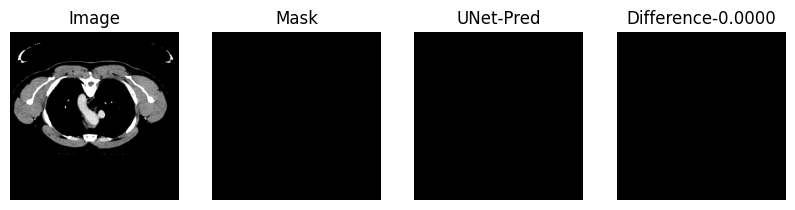

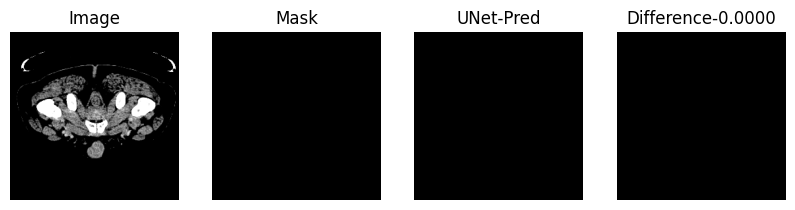

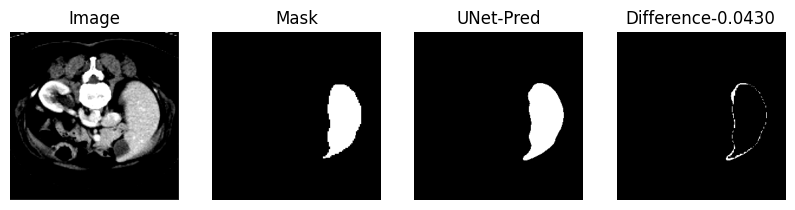

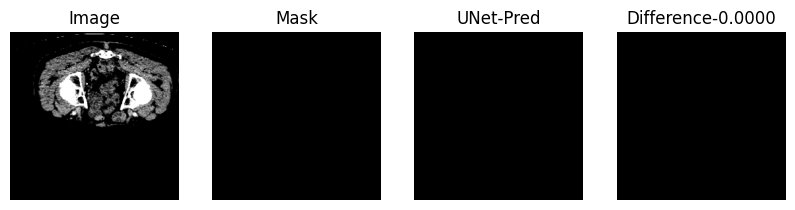

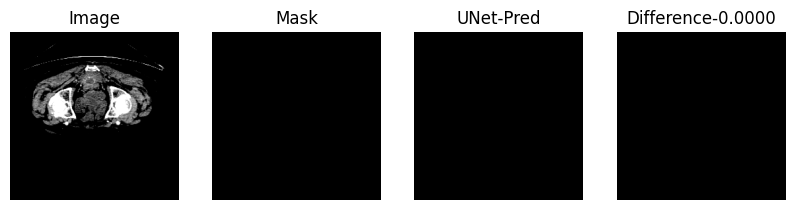

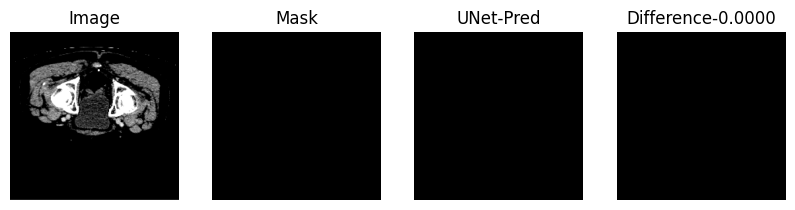

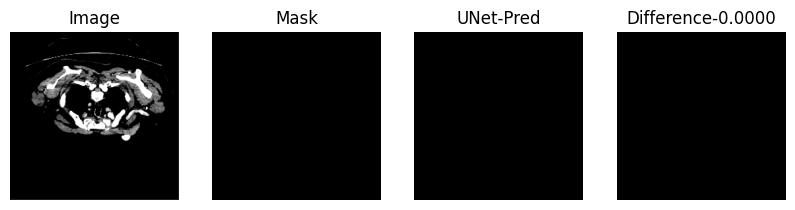

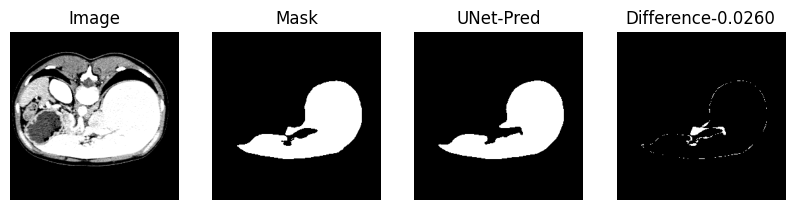

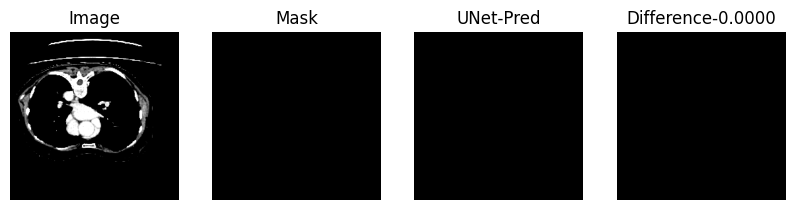

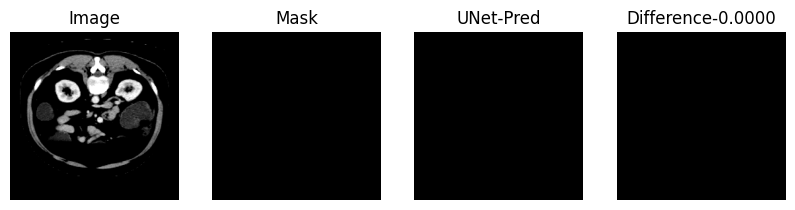

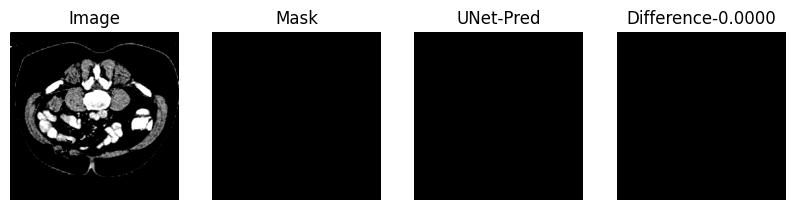

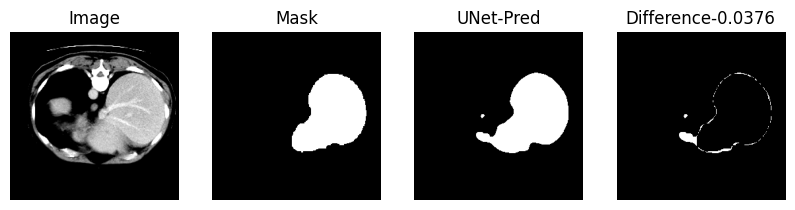

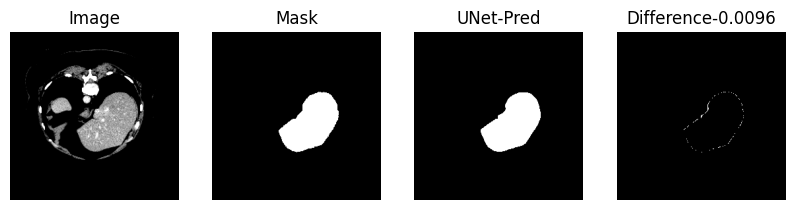

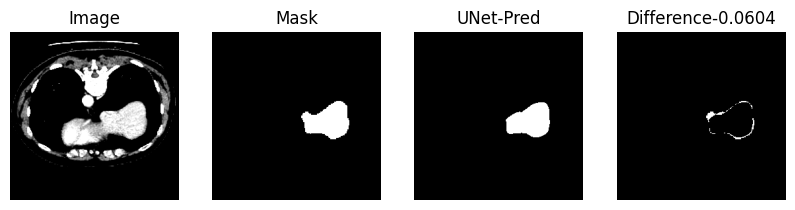

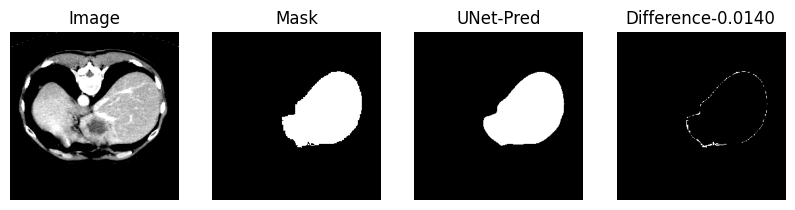

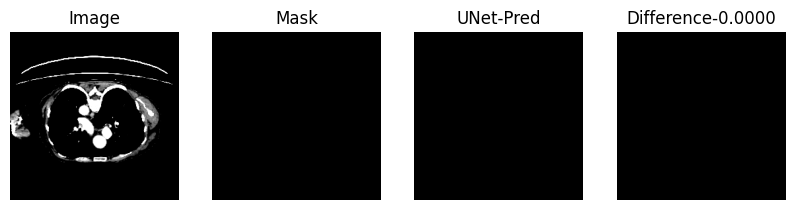

In [30]:
for i in range(16):
    
    fig, axes = plt.subplots(1, 4, figsize=(10, 5))  # 1 row, 3 columns
    
    axes[0].imshow(imgs[i][0].cpu().numpy(), cmap='gray')
    axes[0].set_title("Image")
    axes[0].axis("off")
    
    axes[1].imshow(masks[i][0].cpu().numpy(), cmap='gray')
    axes[1].set_title("Mask")
    axes[1].axis("off")
    
    axes[2].imshow(preds[i][0].cpu().numpy(), cmap='gray')
    axes[2].set_title("UNet-Pred")
    axes[2].axis("off")
    
    difference = torch.abs(masks[i][0] - preds[i][0]).cpu().numpy()
    axes[3].imshow(difference, cmap='gray')
    axes[3].set_title( f'Difference-{loss[i]:.4f}')
    axes[3].axis("off")
    
    plt.savefig(f'/kaggle/working/{name}/infer/img-{i}.png', bbox_inches='tight')

plt.show()

In [32]:
model = UNet(n_classes=1).to(device)

i = 7

img = imgs[i].unsqueeze(0)
mask = masks[i][0]

with torch.no_grad():
    unet_out = model(img)
    pred = model(img)

pred = torch.argmax(torch.softmax(pred, dim=1), dim =1)
print(pred.shape)

torch.Size([1, 256, 256])


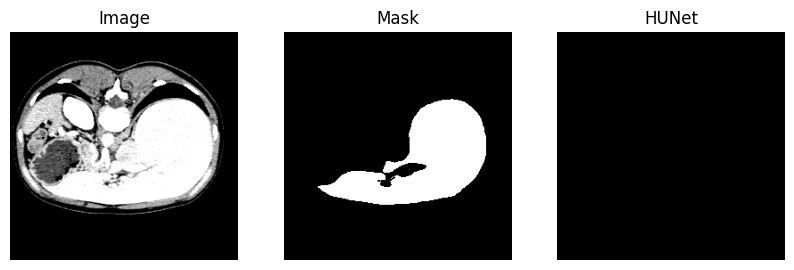

torch.Size([1, 1, 256, 256])


In [35]:
fig, axes = plt.subplots(1, 3, figsize=(10, 5))  # 1 row, 3 columns

axes[0].imshow(img[0][0].cpu().numpy(), cmap='gray')
axes[0].set_title("Image")
axes[0].axis("off")

axes[1].imshow(mask.cpu().numpy(), cmap='gray')
axes[1].set_title("Mask")
axes[1].axis("off")

axes[2].imshow(pred[0].cpu().numpy(), cmap='gray')
axes[2].set_title("HUNet")
axes[2].axis("off")
    

plt.show()
print(unet_out.shape)


## Log graphs

In [40]:
logs = pd.read_csv(f'/kaggle/input/unet-bce/UNet_dice_256_2.csv')
logs.head()

,epoch,time,train_loss,val_loss,dice_train,dice_val,dice_tm_train,dice_tm_val,mIou_train,mIou_val,precision_train,precision_val,recall_train,recall_val
0,1,1113.14,0.0556,0.0129,0.7740,0.8869,0.4140,0.6974,0.3658,0.6337,0.6619,0.8760,0.6029,0.9050
1,2,967.44,0.0105,0.0087,0.9070,0.9271,0.7388,0.7982,0.6801,0.7427,0.9225,0.9152,0.8993,0.9393
2,3,948.27,0.0074,0.0075,0.9306,0.9347,0.8025,0.8134,0.7506,0.7609,0.9405,0.9415,0.9297,0.9260
3,4,943.34,0.0059,0.0063,0.9446,0.9548,0.8387,0.8635,0.7913,0.8137,0.9516,0.9672,0.9437,0.9228
4,5,956.02,0.0053,0.0053,0.9521,0.9603,0.8589,0.8836,0.8138,0.8388,0.9554,0.9584,0.9502,0.9485


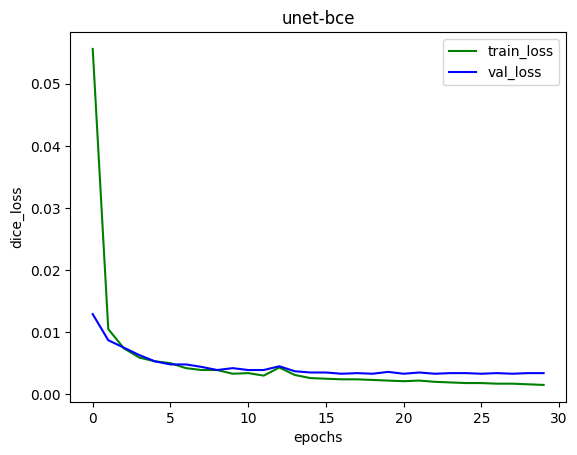

In [41]:
plt.title(name)
plt.plot(logs.train_loss, 'g')
plt.plot(logs.val_loss, 'b')
plt.xlabel('epochs')
plt.ylabel('dice_loss')
plt.legend(['train_loss', 'val_loss'])
plt.savefig(f'/kaggle/working/{name}/dice_loss.jpg')
plt.show()

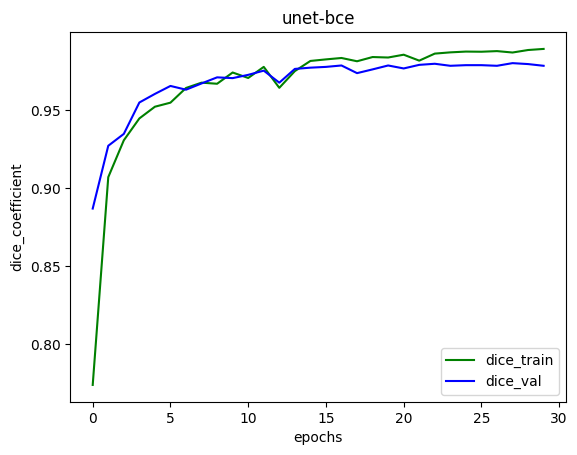

In [42]:
plt.title(name)
plt.plot(logs.dice_train, 'g')
plt.plot(logs.dice_val, 'b')
plt.xlabel('epochs')
plt.ylabel('dice_coefficient')
plt.legend(['dice_train', 'dice_val'])
plt.savefig(f'/kaggle/working/{name}/dice_coefficient.jpg')
plt.show()


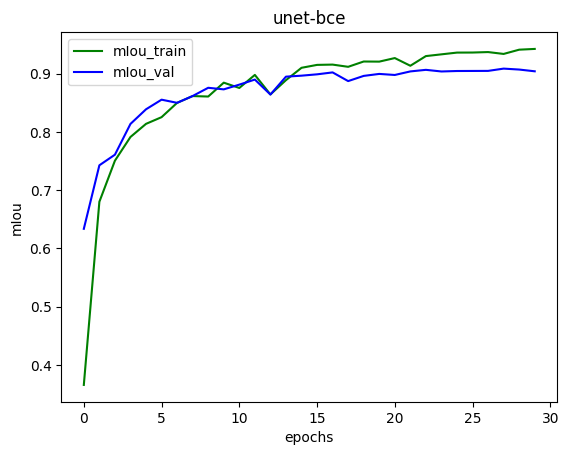

In [43]:
plt.title(name)
plt.plot(logs.mIou_train, 'g')
plt.plot(logs.mIou_val, 'b')
plt.xlabel('epochs')
plt.ylabel('mIou')
plt.legend(['mIou_train', 'mIou_val'])
plt.savefig(f'/kaggle/working/{name}/miou.jpg')
plt.show()

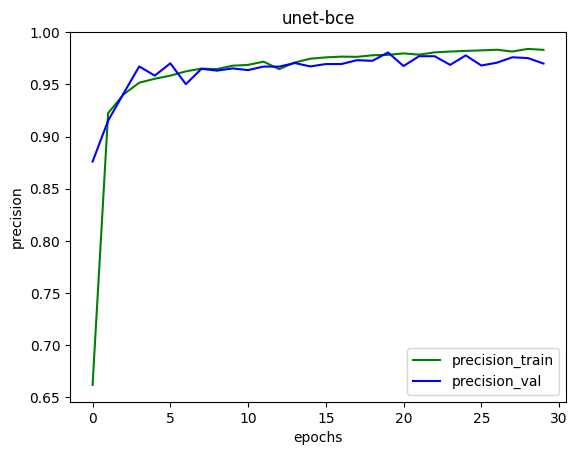

In [44]:
plt.title(name)
plt.plot(logs.precision_train, 'g')
plt.plot(logs.precision_val, 'b')
plt.xlabel('epochs')
plt.ylabel('precision')
plt.legend(['precision_train', 'precision_val'])
plt.savefig(f'/kaggle/working/{name}/precision.jpg')
plt.show()

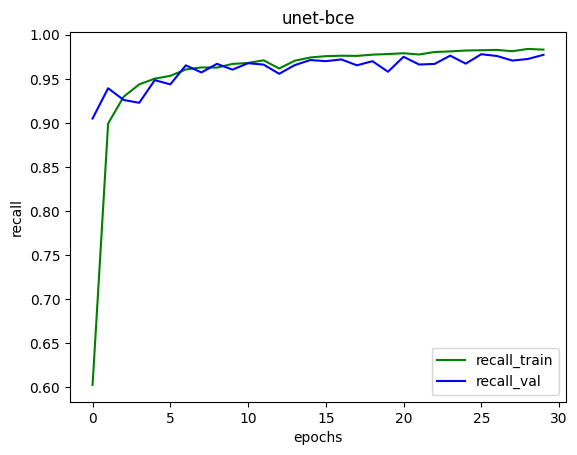

In [45]:
plt.title(name)
plt.plot(logs.recall_train, 'g')
plt.plot(logs.recall_val, 'b')
plt.xlabel('epochs')
plt.ylabel('recall')
plt.legend(['recall_train', 'recall_val'])
plt.savefig(f'/kaggle/working/{name}/recall.jpg')
plt.show()

In [46]:
!zip -r unet-bce.zip /kaggle/working/unet-bce

  adding: kaggle/working/unet-bce/ (stored 0%)
  adding: kaggle/working/unet-bce/recall.jpg (deflated 33%)
  adding: kaggle/working/unet-bce/infer/ (stored 0%)
  adding: kaggle/working/unet-bce/infer/img-10.png (deflated 11%)
  adding: kaggle/working/unet-bce/infer/img-7.png (deflated 11%)
  adding: kaggle/working/unet-bce/infer/img-12.png (deflated 12%)
  adding: kaggle/working/unet-bce/infer/img-4.png (deflated 14%)
  adding: kaggle/working/unet-bce/infer/img-6.png (deflated 13%)
  adding: kaggle/working/unet-bce/infer/img-11.png (deflated 9%)
  adding: kaggle/working/unet-bce/infer/img-1.png (deflated 13%)
  adding: kaggle/working/unet-bce/infer/img-8.png (deflated 12%)
  adding: kaggle/working/unet-bce/infer/img-9.png (deflated 12%)
  adding: kaggle/working/unet-bce/infer/img-0.png (deflated 12%)
  adding: kaggle/working/unet-bce/infer/img-13.png (deflated 11%)
  adding: kaggle/working/unet-bce/infer/img-2.png (deflated 9%)
  adding: kaggle/working/unet-bce/infer/img-3.png (deflate